# Lorenz-System

## Projekt für Numerische Methoden für Differentialgleichungen

von Clemens, Emil, Johannes und Max

### Einleitung

wer was wann warum

1963 Ed Lorenz simplified atmospheric system of 12 variables and 12 equations to a toy model of convection.

Butterfly Effect

### Numerische Analyse

_Emil_

### Euler-Methode

_Clemens_

MATLAB Code test
```octave
tx = linspace (-8, 8, 41);
ty = tx;
[xx, yy] = meshgrid (tx, ty);
r = sqrt (xx .^ 2 + yy .^ 2) + eps;
tz = sin (r) ./ r;
```

### Runge-Kutte 4

_Johannes_

### Prädiktor-Korrektor-Verfahren

Die Idee des Prädiktor-Korrektor-Verfahrens ist die Kombination von expliziten und impliziten Verfahren um gute Konvergenzeigenschaften zu erhalten, ohne dabei den Rechenleistungspreis der impliziten Verfahren zu zahlen.

Dazu wird als Prädiktor ein Schritt eines expliziten Verfahrens ausgeführt und das Ergebnis in den Korrektor, einer impliziten Gleichung, eingesetzt um kein Gleichungssystem lösen zu müssen.

Bei Einschrittverfahren sieht die Prädiktor-Evaluierung-Korrektor-Evaluierung Schleife wie folgt aus:

\begin{align*}
&(P) \qquad \tilde{y}_{n+1} = y_n + h \ \Phi_P(t_n,\, y_n,\, f_n,\, h) \\
&(E) \qquad \tilde{f}_{n+1} = f(t_{n+1},\, \tilde{y}_{n+1}) \\
&(C) \qquad y_{n+1} = y_n + h \ \Phi_C(t_n,\, y_n,\, \tilde{y}_{n+1},\, f_n,\, \tilde{f}_{n+1},\, h) \\
&(E) \qquad f_{n+1} = f(t_{n+1},\, y_{n+1})
\end{align*}

Wobei hier $\Phi_P$ das explizite und $\Phi_C$ das implizite Einschrittverfahren bezeichnet.

Um die Genauigkeit zu erhöhren, kann man z.B. nun den Korrektor mehrmals anwenden und kommt so zu dem Modus P(EC)$^k$E bzw. wenn man ihn so oft anwendet bis Konvergenz zu einer gewünschten Toleranz vorliegt: P(EC)$^\infty$E.

Oft verwendete Prädiktor-Korrektor-Verfahren:
- Methode von Heun: explizites Euler-Verfahren als Prädiktor und Crank-Nicolson als Korrektor
- ABM: Adams-Bashforth als Prädiktor und Adams-Moulton als Korrektor

Die Kombination von Adams-Bashforth und Adams-Moulton wurde hier als Mischung aus P(EC)$^k$E und P(EC)$^\infty$E implementiert und ein Schritt läuft so ab:

\begin{align*}
&(P) \qquad \tilde{y}_{n+1} = y_n + h \ \sum_{j=0}^s a_j \ f(t_{n-j},\, y_{n-j}) \\
&(C) \qquad y_{n+1} = y_n + h \ \sum_{j=0}^{s-1} b_j \ f(t_{n-j},\, y_{n-j}) + h \ b_{-1} \ f(t_{n+1},\, \tilde{y}_{n+1})
\end{align*}

Dabei ist $s$ die Anzahl der Schritte und $(a_j)_{j=0}^s$ sowie $(b_j)_{j=-1}^{s-1}$ die Koeffizienten der Mehrschrittverfahren, die man aus einer Polynominterpolation gewinnt.

(C) wird hier so oft wiederholt bis die gewünschte Konvergenz oder die vorgegebene Anzahl an Zyklen erreicht ist.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11.2, 6.3))
plt.rc("animation", html="jshtml")

In [2]:
class LorenzSystem:
    
    def __init__(self, rho, r, b):
        '''initialize the object with the parameters rho, r and b of the system'''
        
        self.rho = rho
        self.r = r
        self.b = b
                
    def ODE(self, state):
        '''differential equation of the object: x'=rho*(x-y), y'=x*(r-z)-y, z'=x*y-b*z'''
        
        x, y, z = state
        return np.array([self.rho*(x-y), x*(self.r-z)-y, x*y-self.b*z])
    
    def solve(self, state0, h=0.01, N=1000, steps=4, iters=1, tol=0.01):
        '''
        solves the ODE with given initial state and discretized time interval using ABE
        
        state0 ... initial state vector [x, y, z]
        h ........ step size
        N ........ number of time steps
        steps .... number of interpolation steps per time step
        iters .... number of iterations for each evaluation-correction cycle
        tol ...... if this tolerance is exceeded the evaluation-correction cycle breaks
        '''
        
        state0 = np.array(state0)
        steps = steps if 0 < steps < 5 else 4
        
        # initialize state array with initial state
        states = np.zeros((N+1, 3))
        states[0] = state0
        
        # initialize ODE function values
        fvals = np.zeros((N+1, 3))
        fvals[0] = self.ODE(state0)
        
        # coefficients for Adams-Bashforth method
        coeffsAB = (1,
                    [-1/2, 3/2],
                    [5/12, -16/12, 23/12],
                    [-9/24, 37/24, -59/24, 55/24])
        
        # coefficients for Adams-Moulton method
        coeffsAM = ([1/2, 1/2],
                    [-1/12, 2/3, 5/12],
                    [1/24, -5/24, 19/24, 9/24],
                    [-19/720, 106/720, -264/720, 646/720, 251/720])
        
        # increasing steps until desired order is reached
        for s in range(steps):
            # predictor: Adams-Bashforth method
            states[s+1] = states[s] + h * np.dot(coeffsAB[s], fvals[:s+1])
            
            # evaluation-corrector cycle with Adams-Moulton
            for i in range(iters):
                new = states[s] + h * (np.dot(coeffsAM[s][:-1], fvals[:s+1]) + coeffsAM[s][-1] * self.ODE(states[s+1]))
                cond = np.allclose(states[s+1], new, atol=tol)
                states[s+1] = new
                if cond:
                    break
            
            # evaluation
            fvals[s+1] = self.ODE(states[s+1])
        
        # main loop
        for n in range(N-steps+1):
            # predictor: Adams-Bashforth method
            states[n+steps] = states[n+steps-1] + h * np.dot(coeffsAB[steps-1], fvals[n:n+steps])
            
            # evaluation-corrector cycle with Adams-Moulton
            for i in range(iters):
                new = states[n+steps-1] + h * (np.dot(coeffsAM[steps-1][:-1], fvals[n:n+steps]) + coeffsAM[steps-1][-1] * self.ODE(states[n+steps]))
                cond = np.allclose(new, states[n+steps], atol=tol)
                states[n+steps] = new
                if cond:
                    break
            
            # evaluation
            fvals[n+steps] = self.ODE(states[n+steps])
        
        return states
    
    def plot(self, *args, h=0.01, N=1000, steps=4, iters=1, tol=0.01):
        '''plots the solved system for multiple initial conditions on a 3D axis'''
        
        fig = plt.figure()
        ax = fig.gca(projection="3d")
        
        ax.w_xaxis.pane.set_color("w")
        ax.w_yaxis.pane.set_color("w")
        ax.w_zaxis.pane.set_color("w")
        ax.set_xlabel("x Axis")
        ax.set_ylabel("y Axis")
        ax.set_zlabel("z Axis")
        ax.set_title(fr"Lorenz System for $\rho$ = {self.rho:.0f}, r = {self.r:.0f}, b = {self.b:.2f}", pad=16)
        
        for state in args:
            states = self.solve(state, h=h, N=N)
            ax.plot(*states.T, linewidth=0.5, alpha=0.95, label=f"initial state = {state}")
            
        plt.legend()
        plt.show()
    
    def animate(self, *args, h=0.01, N=1000, steps=4, iters=1, tol=0.01, save=False):
        '''animates the changing of the system with respect to time'''
        
        states = ()
        for arg in args:
            states += self.solve(arg, h=h, N=N),

        fig = plt.figure()
        ax = fig.gca(projection="3d")
        
        ax.w_xaxis.pane.set_color("w")
        ax.w_yaxis.pane.set_color("w")
        ax.w_zaxis.pane.set_color("w")
        ax.set_xlabel("x Axis")
        ax.set_ylabel("y Axis")
        ax.set_zlabel("z Axis")
        ax.set_xlim3d([-20, 20])
        ax.set_ylim3d([-25, 25])
        ax.set_zlim3d([0, 50])
        ax.set_title(fr"Lorenz System for $\rho$ = {self.rho:.0f}, r = {self.r:.0f}, b = {self.b:.2f}", pad=16)
        
        lines = ()
        points = ()
        for n, state in enumerate(states):
            lines += ax.plot(state[0:1, 0], state[0:1, 1], state[0:1, 2], color=f"C{n}", linewidth=0.5, alpha=0.95)[0],
            points += ax.plot(state[0:1, 0], state[0:1, 1], state[0:1, 2], ".", color=f"C{n}")[0],
        plt.close()
        
        def init():
            for state, line, point in zip(states, lines, points):
                line.set_data([], [])
                line.set_3d_properties([])
                point.set_data([], [])
                point.set_3d_properties([])
            return (*lines, *points)

        def update(i):
            for state, line, point in zip(states, lines, points):
                line.set_data(state.T[:2, :i])
                line.set_3d_properties(state.T[2, :i])
                point.set_data(state[i, :2])
                point.set_3d_properties(state[i, 2])
            return (*lines, *points)
        
        anim = FuncAnimation(fig, update, N, init_func=init, interval=4, blit=True)
        
        if save:
            anim.save("anim.mp4", bitrate=5000)
        else:
            return anim

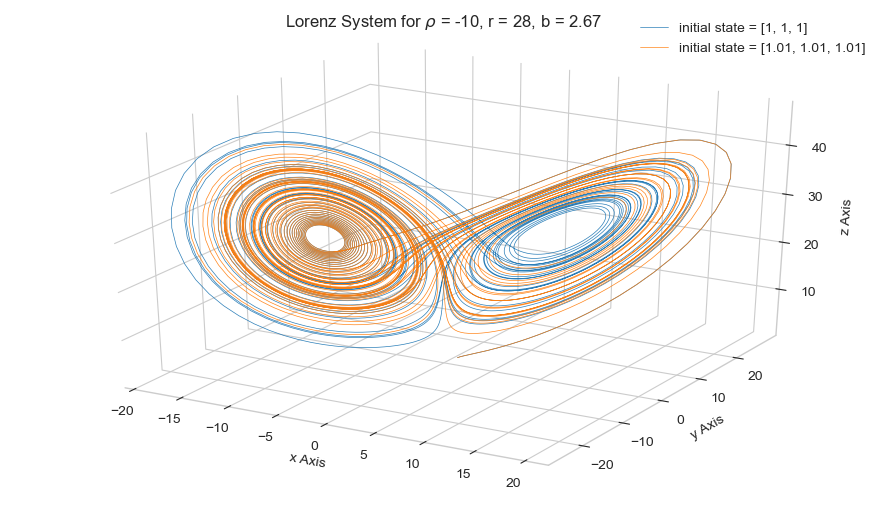

In [3]:
rho = -10
r = 28
b = 8 / 3

state1 = [1, 1, 1]
state2 = [1.01, 1.01, 1.01]
h = 0.01
N = 5000

LS = LorenzSystem(rho, r, b)
LS.plot(state1, state2, h=h, N=N)

### Beobachtungen

schaut leiwand aus

„bei gleicher Schrittweite ist Euler explizit ganz schlecht, weil…

Runge-Kutte 4 besser aber auch nicht gut, weil …

Prediktor-Korrektor sehr gut, was man daran erkennt…

Wir erklären uns das so: …“

### Quellen

[Wikipedia Lorenz-System](https://en.wikipedia.org/wiki/Lorenz_system)

[Wikipedia Predictor-corrector method](https://en.wikipedia.org/wiki/Predictor–corrector_method)